In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
%matplotlib inline

survey = pd.read_csv('survey.csv')
survey.iloc[0]

C:\Users\priyamanivan\Anaconda4\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Timestamp                    2014-08-27 11:29:31
Age                                           37
Gender                                    Female
Country                            United States
state                                         IL
self_employed                                NaN
family_history                                No
treatment                                    Yes
work_interfere                             Often
no_employees                                6-25
remote_work                                   No
tech_company                                 Yes
benefits                                     Yes
care_options                            Not sure
wellness_program                              No
seek_help                                    Yes
anonymity                                    Yes
leave                              Somewhat easy
mental_health_consequence                     No
phys_health_consequence                       No
coworkers           

# Data Cleanup

In [2]:
#anon = survey['anonymity']
#mvp = survey['mental_vs_physical']
#dk_cols = [anon, mvp]
#for n in dk_cols:
 #   for i in range(len(anon)):
  #      if n.iloc[i] == "Don't know":
   #         n.iloc[i] = 'dk'
            
#survey['anonymity'] = anon
#survey['mental_vs_physical'] = mvp

In [3]:
survey.isnull().sum()

Timestamp                       0
Age                             0
Gender                          0
Country                         0
state                         515
self_employed                  18
family_history                  0
treatment                       0
work_interfere                264
no_employees                    0
remote_work                     0
tech_company                    0
benefits                        0
care_options                    0
wellness_program                0
seek_help                       0
anonymity                       0
leave                           0
mental_health_consequence       0
phys_health_consequence         0
coworkers                       0
supervisor                      0
mental_health_interview         0
phys_health_interview           0
mental_vs_physical              0
obs_consequence                 0
comments                     1095
dtype: int64

In [4]:
state = survey[survey['state'].isnull()]

In [5]:
#Looks like information for state is missing because there were options only for states in the USA.

In [6]:
survey['self_employed'].value_counts()

No     1095
Yes     146
Name: self_employed, dtype: int64

In [7]:
#We can try filling in self_employed information using other indicators in the data, like number of colleagues.

In [8]:
se_isnull = survey[survey['self_employed'].isnull()]
se_isnull['no_employees'].value_counts()

6-25              6
26-100            5
100-500           3
1-5               2
500-1000          1
More than 1000    1
Name: no_employees, dtype: int64

In [9]:
#If they answered yes to this, I'm guessing they must currently have supervisors and are not self-employed.
#I will fill in the Nan's as no's.

In [10]:
se = survey.loc[:,'self_employed']
for i in range(len(se)):
    if pd.isnull(se.iloc[i]):
        se.iloc[i] = "No"
survey['self_employed'] = se

C:\Users\priyamanivan\Anaconda4\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
#Cleaning up gender column
survey["Gender"].value_counts()

Male                                              615
male                                              206
Female                                            121
M                                                 116
female                                             62
F                                                  38
m                                                  34
f                                                  15
Make                                                4
Male                                                3
Woman                                               3
Man                                                 2
Cis Male                                            2
Female (trans)                                      2
Female                                              2
Female (cis)                                        1
cis-female/femme                                    1
male leaning androgynous                            1
Mal                         

In [12]:
survey.loc[survey['Gender'].str.contains('trans', case=False,na=False),'Gender']=0
survey.loc[survey['Gender'].str.contains('queer', case=False,na=False),'Gender']=0
survey.loc[survey['Gender'].str.contains('fluid', case=False,na=False),'Gender']=0
survey.loc[survey['Gender'].str.contains('fem', case=False,na=False),'Gender']=2
survey.loc[survey['Gender'].str.contains('Woman', case=False,na=False),'Gender']=2
survey.loc[survey['Gender'].str.contains('m', case=False,na=False),'Gender']=1
survey.loc[survey['Gender'].str.contains('f', case=False,na=False),'Gender']=2
survey.loc[survey['Gender'].str.contains('a', case=False,na=False),'Gender']=0
survey.loc[survey['Gender'].str.contains('e', case=False,na=False),'Gender']=0
survey.loc[survey['Gender'].str.contains('p', case=False,na=False),'Gender']=0
survey.loc[survey['Gender'].str.contains('u', case=False,na=False),'Gender']=0
survey["Gender"].value_counts()

1    994
2    247
0     18
Name: Gender, dtype: int64

In [13]:
#Cleaning up Age column
survey['Age'].value_counts()

 29             85
 32             82
 26             75
 27             71
 33             70
 28             68
 31             67
 34             65
 30             63
 25             61
 35             55
 23             51
 24             46
 37             43
 38             39
 36             37
 39             33
 40             33
 43             28
 41             21
 22             21
 42             20
 21             16
 45             12
 46             12
 44             11
 19              9
 18              7
 20              6
 48              6
 50              6
 51              5
 56              4
 49              4
 57              3
 54              3
 55              3
 47              2
 60              2
 11              1
 8               1
 5               1
 99999999999     1
-1726            1
 53              1
 58              1
 61              1
 62              1
 65              1
 72              1
 329             1
-29              1
-1          

In [14]:
survey[(survey<100) & (survey>0)].mean(axis=0,skipna=True,numeric_only=True)

Age    32.019139
dtype: float64

In [15]:
age = survey.loc[:,'Age']

In [16]:
for i in range(len(age)):
    if age.iloc[i] < 0:
        age.iloc[i] = 32
    elif age.iloc[i] > 100:
        age.iloc[i] = 32

C:\Users\priyamanivan\Anaconda4\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [17]:
age.mean()

32.01906274821287

In [18]:
survey['Age'] = age

In [19]:
survey.isnull().sum()

Timestamp                       0
Age                             0
Gender                          0
Country                         0
state                         515
self_employed                   0
family_history                  0
treatment                       0
work_interfere                264
no_employees                    0
remote_work                     0
tech_company                    0
benefits                        0
care_options                    0
wellness_program                0
seek_help                       0
anonymity                       0
leave                           0
mental_health_consequence       0
phys_health_consequence         0
coworkers                       0
supervisor                      0
mental_health_interview         0
phys_health_interview           0
mental_vs_physical              0
obs_consequence                 0
comments                     1095
dtype: int64

In [20]:
survey['self_employed'].value_counts()

No     1113
Yes     146
Name: self_employed, dtype: int64

In [21]:
drop_cols = ['Timestamp','Country','comments','state']
survey = survey.drop(drop_cols, axis = 1)
text_cols = survey.select_dtypes(include=['object'])
text_cols.columns

#for col in text_cols.columns:
 #   survey[col] = survey[col].astype('category')

Index(['Gender', 'self_employed', 'family_history', 'treatment',
       'work_interfere', 'no_employees', 'remote_work', 'tech_company',
       'benefits', 'care_options', 'wellness_program', 'seek_help',
       'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence'],
      dtype='object')

# Graphical EDA

What features might affect whether or not an employee seeks out treatment?

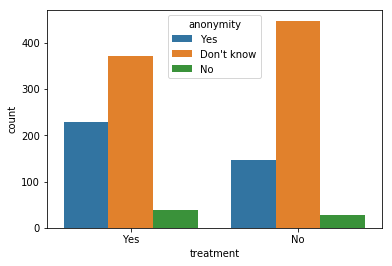

In [22]:
sns.countplot(x = 'treatment', hue = 'anonymity', data = survey)

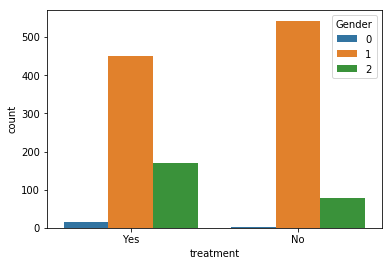

In [23]:
sns.countplot(x = 'treatment', hue = 'Gender', data = survey)

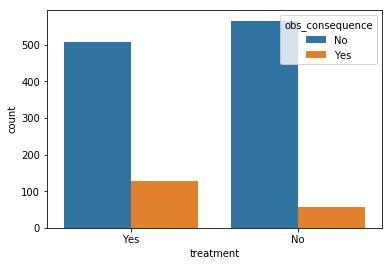

In [24]:
sns.countplot(x = 'treatment', hue = 'obs_consequence', data = survey)

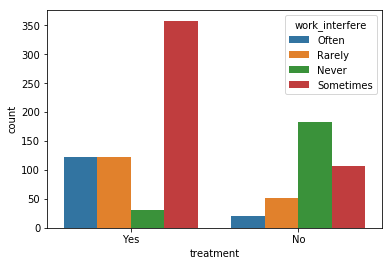

In [25]:
sns.countplot(x = 'treatment', hue = 'work_interfere', data = survey)

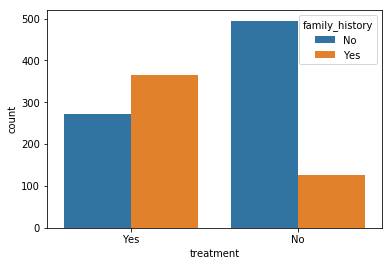

In [26]:
sns.countplot(x = 'treatment', hue = 'family_history', data = survey)

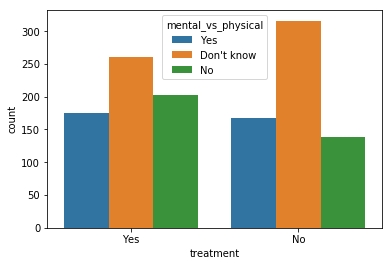

In [27]:
sns.countplot(x = 'treatment', hue = 'mental_vs_physical', data = survey)

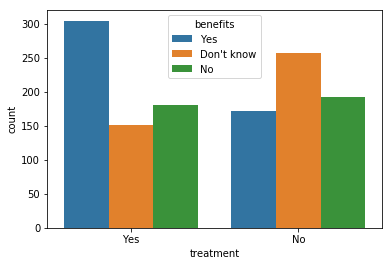

In [28]:
sns.countplot(x = 'treatment', hue = 'benefits', data = survey)

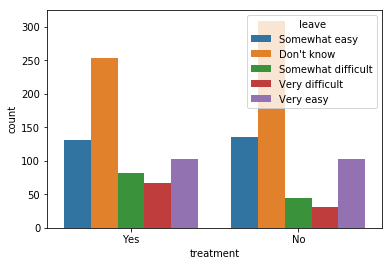

In [29]:
sns.countplot(x = 'treatment', hue = 'leave', data = survey)

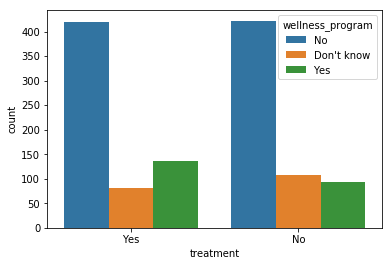

In [30]:
sns.countplot(x = 'treatment', hue = 'wellness_program', data = survey)

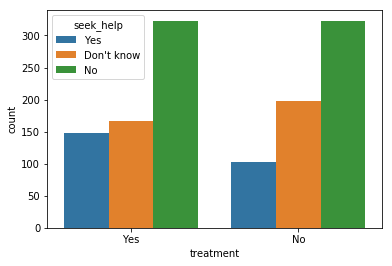

In [31]:
sns.countplot(x = 'treatment', hue = 'seek_help', data = survey)

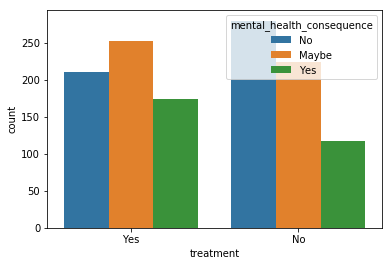

In [32]:
sns.countplot(x = 'treatment', hue = 'mental_health_consequence', data = survey)

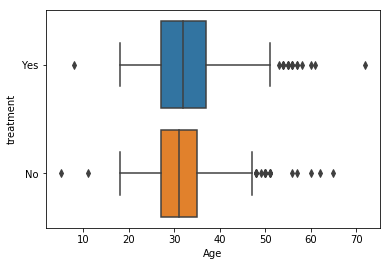

In [33]:
sns.boxplot(x = 'Age', y ='treatment', data = survey)
plt.show()

# Feature Transformation and Selection

In [34]:
from sklearn.preprocessing import LabelEncoder

def encode_features(df):
    
    num_missing = df['work_interfere'].isnull()
    num_missing = num_missing[num_missing==True]
    df = df.drop(df.index[num_missing.index], axis = 0)
    
    text_cols = df.select_dtypes(include=['object'])
    enc_cols = text_cols.columns.values
    
    le = LabelEncoder()
    for col in enc_cols:
    
        df[col] = le.fit_transform(df[col].astype(str))
    
    return df

transformed_survey = encode_features(survey)
transformed_survey

,Age,Gender,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,2,0,0,1,1,4,0,1,2,...,2,2,1,1,1,2,1,0,2,0
1,44,1,0,0,0,2,5,0,0,0,...,0,0,0,1,0,0,1,1,0,0
2,32,1,0,0,0,2,4,0,1,1,...,0,1,1,1,2,2,2,2,1,0
3,31,1,0,1,1,1,2,0,1,1,...,1,1,2,2,1,0,0,0,1,1
4,31,1,0,0,0,0,1,1,1,2,...,0,0,1,1,1,2,2,2,0,0
5,33,1,0,1,0,3,4,0,1,2,...,0,0,1,1,2,2,1,0,0,0
6,35,2,0,1,1,3,0,1,1,1,...,1,1,0,0,1,0,1,1,0,0
7,39,1,0,0,0,0,0,1,1,1,...,2,0,1,1,0,0,1,1,1,0
8,42,2,0,1,1,3,1,0,1,2,...,1,3,0,1,2,2,1,0,1,0
9,23,1,0,0,0,0,2,0,1,0,...,0,0,1,1,2,2,0,0,2,0


In [35]:
def select_features(df, num):
    
        df = df.corr()
        abs_corr = df['treatment'].sort_values(axis=0)
        selected_features = abs_corr.nlargest(num+1, keep='first').sort_values()
        selected_features = selected_features[selected_features.index != 'treatment']
        selected_features = selected_features.reset_index()
        selected =  np.asarray(selected_features['index'])
        return selected

features = select_features(transformed_survey, 4)
print(features)

['care_options' 'benefits' 'family_history' 'work_interfere']


# Logistic Regression

In [36]:
def train_and_test(df, cols):
    accuracy = []
    sensitivity = []
    specificity = []
    
    train = df[features]
    
    num_missing = survey['work_interfere'].isnull()
    num_missing = num_missing[num_missing==True]
    df2 = survey.copy()
    df2 = df2.drop(df2.index[num_missing.index], axis = 0)
    target = df2['treatment']
    kf = KFold(n=len(df), n_folds=10, shuffle=True, random_state=3)
    
    for train_index, test_index in kf:
        
        X_train, X_test = train.iloc[train_index], train.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        logistic_model = LogisticRegression()
        logistic_model.fit(X_train, y_train)
    
        fitted_labels = logistic_model.predict(X_test)
        X_test.loc[:,'predicted_labels'] = fitted_labels
        matches = X_test.loc[:,'predicted_labels']==y_test
        correct_predictions = X_test[matches]
        
        a = len(correct_predictions) / len(X_test)
        
        true_positives = len(X_test.loc[(X_test.loc[:,'predicted_labels']=='Yes') & (y_test=='Yes')])
        false_negatives = len(X_test.loc[(X_test.loc[:,'predicted_labels']=='No') & (y_test=='Yes')])
        true_negatives = len(X_test.loc[(X_test.loc[:,'predicted_labels']=='No') & (y_test=='No')])
        false_positives = len(X_test.loc[(X_test.loc[:,'predicted_labels']=='Yes') & (y_test=='No')])
        
        se = (true_positives) / (true_positives + false_negatives)
        sp = (true_negatives) / (false_positives + true_negatives)
        
        accuracy.append(a)
        sensitivity.append(se)
        specificity.append(sp)
    
    print("Accuracy mean =",np.mean(accuracy))
    print("Accuracy standard deviation =",np.std(accuracy))
    print(accuracy)
    print("Sensitivity mean =",np.mean(sensitivity))
    print("Sensitivity standard deviation =",np.std(sensitivity))
    print(sensitivity)
    print("Specificity mean =",np.mean(specificity))
    print("Specificity standard deviation =",np.std(specificity))
    print(specificity)
   
train_and_test(transformed_survey,features)

C:\Users\priyamanivan\Anaconda4\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\priyamanivan\Anaconda4\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Accuracy mean = 0.772868686869
Accuracy standard deviation = 0.036928834292
[0.77, 0.77, 0.81, 0.75, 0.76, 0.7171717171717171, 0.8282828282828283, 0.8181818181818182, 0.7171717171717171, 0.7878787878787878]
Sensitivity mean = 0.883155332259
Sensitivity standard deviation = 0.0400406981802
[0.9130434782608695, 0.8529411764705882, 0.953125, 0.875, 0.8666666666666667, 0.8928571428571429, 0.9027777777777778, 0.9154929577464789, 0.8, 0.8596491228070176]
Specificity mean = 0.576147762399
Specificity standard deviation = 0.0639316979022
[0.45161290322580644, 0.59375, 0.5555555555555556, 0.5909090909090909, 0.6, 0.4883720930232558, 0.6296296296296297, 0.5714285714285714, 0.5897435897435898, 0.6904761904761905]


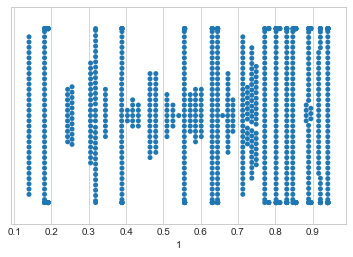

(array([1, 0], dtype=int64),
 {0: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False),
  1: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False)},
             1         0
 0    0.479804  0.520196
 1    0.388172  0.611828
 2    0.479384  0.520616
 3    0.737001  0.262999
 4    0.255141  0.744859
 5    0.920883  0.079117
 6    0.854712  0.145288
 7    0.304890  0.695110
 8    0.940715  0.059285
 9    0.139871  0.860129
 10   0.556181  0.443819
 11   0.181460  0.818540
 12   0.940715  0.059285
 13   0.417608  0.582392
 14   0.181460  0.818540
 15   0.854921  

In [37]:
def predict_probabilities(df):

    models = {}

    unique_treatment = df['treatment'].unique()
    
    testing_probs = pd.DataFrame() 
    
    for i in unique_treatment:
        model = LogisticRegression()
    
        X_train = df[features]
        y_train = df['treatment'] == i

        model.fit(X_train, y_train)
        models[i] = model
        
    for i in unique_treatment:
        X_test = df[features]
        testing_probs[i] = models[i].predict_proba(X_test)[:,1]
        
    predicted_treatment = testing_probs.idxmax(axis=1)
    sns.set_style("whitegrid")
    sns.swarmplot(testing_probs[1])
    plt.show()
    return unique_treatment, models, testing_probs, predicted_treatment

predict_probabilities(transformed_survey)